In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the dataset folder in Google Drive
data_path = '/content/drive/MyDrive/unzipped_dataset/filter40'

# List files in the dataset folder /content/drive/MyDrive/extracted_files/
os.listdir(data_path)


['Person_01',
 'Person_02',
 'Person_03',
 'Person_04',
 'Person_05',
 'Person_06',
 'Person_07',
 'Person_08',
 'Person_09',
 'Person_10',
 'Person_11',
 'Person_12',
 'Person_13',
 'Person_14',
 'Person_15',
 'Person_16',
 'Person_17',
 'Person_18',
 'Person_19',
 'Person_20',
 'Person_21',
 'Person_22',
 'Person_23',
 'Person_24',
 'Person_25',
 'Person_26',
 'Person_27',
 'Person_28',
 'Person_29',
 'Person_30']

In [ ]:
# Define constants
#data_path = '/content/drive/MyDrive/unzipped_dataset/filter40'
input_shape = (224, 224, 3)  # Resize images to 299x299 for InceptionV3
photo_size = 224

In [ ]:
# Setup ImageDataGenerator with rescaling and data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    validation_split=0.2  # Split data into training (80%) and validation (20%)
)


In [ ]:
# Load and prepare training data
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)


Found 960 images belonging to 30 classes.


In [ ]:
# Load and prepare validation data
validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 240 images belonging to 30 classes.


In [ ]:
# Create the VGG16 model
def create_vgg_model():
    # Load VGG16 model without the top classifier layers
    base_model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))

    # Freeze all layers except specific layers (example: layers 1-3 and 15-18)
    for layer_idx in range(len(base_model.layers)):
        if layer_idx not in [1, 2, 3, 15, 16, 17, 18]:
            base_model.layers[layer_idx].trainable = False

    # Add new classifier layers
    flat1 = Flatten()(base_model.output)
    dense1 = Dense(4096, activation='relu')(flat1)
    drop1 = Dropout(0.5)(dense1)
    dense2 = Dense(4096, activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(2048, activation='relu')(drop2)  # Additional layer
    drop3 = Dropout(0.5)(dense3)  # Additional layer
    output = Dense(train_generator.num_classes, activation='softmax')(drop3)

    # Define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    return model


In [ ]:
# Instantiate and compile the VGG19 model
vgg_model = create_vgg_model()
vgg_model.summary()
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Train the model and capture the history
history = vgg_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)


Epoch 1/20
30/30 [==============================] - 389s 12s/step - loss: 3.6165 - accuracy: 0.0427 - val_loss: 3.3059 - val_accuracy: 0.1917
Epoch 2/20
30/30 [==============================] - 12s 402ms/step - loss: 2.9751 - accuracy: 0.1562 - val_loss: 2.0260 - val_accuracy: 0.4208
Epoch 3/20
30/30 [==============================] - 13s 415ms/step - loss: 2.1409 - accuracy: 0.3594 - val_loss: 1.3726 - val_accuracy: 0.6208
Epoch 4/20
30/30 [==============================] - 14s 457ms/step - loss: 1.4905 - accuracy: 0.5240 - val_loss: 0.9390 - val_accuracy: 0.6833
Epoch 5/20
30/30 [==============================] - 13s 426ms/step - loss: 1.0973 - accuracy: 0.6531 - val_loss: 0.7669 - val_accuracy: 0.7792
Epoch 6/20
30/30 [==============================] - 14s 454ms/step - loss: 0.8066 - accuracy: 0.7385 - val_loss: 0.5945 - val_accuracy: 0.8208
Epoch 7/20
30/30 [==============================] - 13s 414ms/step - loss: 0.6199 - accuracy: 0.8010 - val_loss: 0.4614 - val_accuracy: 0.8667


In [ ]:
#Save the model

model_save_path = '/content/drive/MyDrive/model.h5'

# Save the model
vgg_model.save(model_save_path)

print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


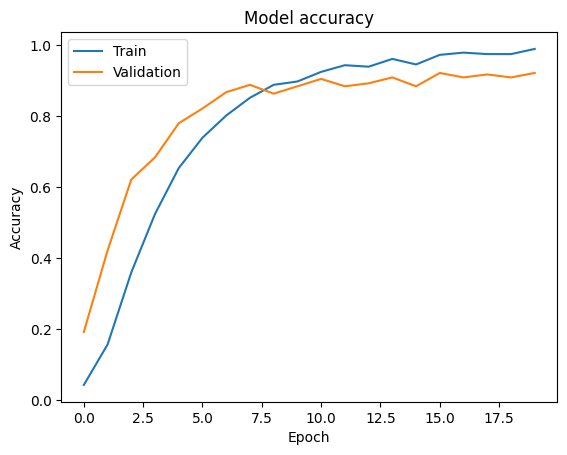

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


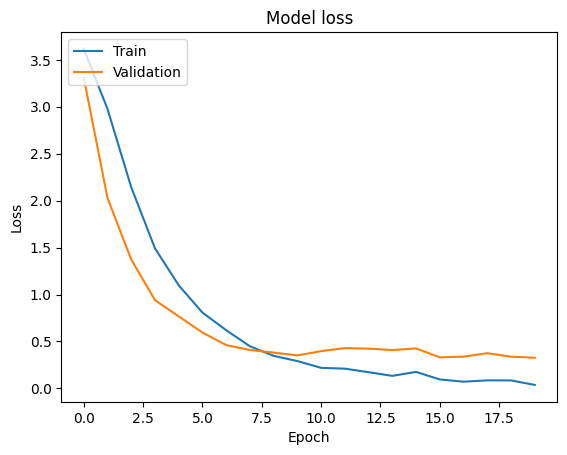

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
validation_generator.reset()
predictions = vgg_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)


8/8 [==============================] - 3s 280ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [ ]:
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


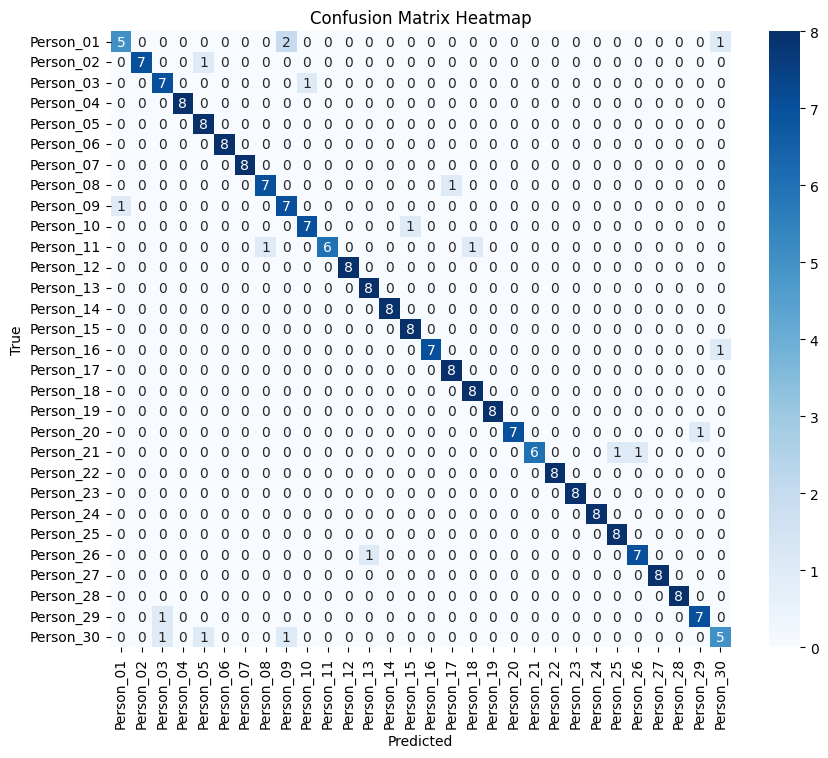

In [ ]:
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



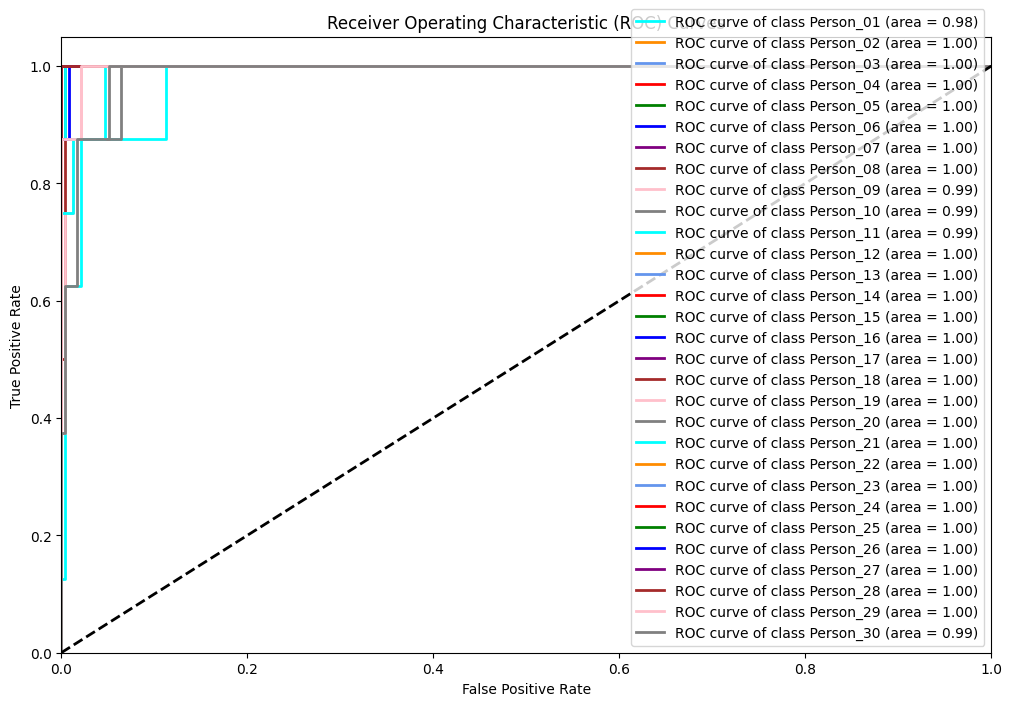

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict the labels for the validation data
validation_generator.reset()
Y_pred = vgg_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')


# Print calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9208
Precision for each class:
Person_01: 0.8333
Person_02: 1.0000
Person_03: 0.7778
Person_04: 1.0000
Person_05: 0.8000
Person_06: 1.0000
Person_07: 1.0000
Person_08: 0.8750
Person_09: 0.7000
Person_10: 0.8750
Person_11: 1.0000
Person_12: 1.0000
Person_13: 0.8889
Person_14: 1.0000
Person_15: 0.8889
Person_16: 1.0000
Person_17: 0.8889
Person_18: 0.8889
Person_19: 1.0000
Person_20: 1.0000
Person_21: 1.0000
Person_22: 1.0000
Person_23: 1.0000
Person_24: 1.0000
Person_25: 0.8889
Person_26: 0.8750
Person_27: 1.0000
Person_28: 1.0000
Person_29: 0.8750
Person_30: 0.7143
